In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split
from numpy import array
from tensorflow import keras
from tensorflow.keras import regularizers, layers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

In [238]:
cleaned = pd.read_pickle("./cleaned.pkl")
cleaned

,Tweet,Product,Sentiment,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google
...,...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion toward brand or product,Google
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Apple
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion toward brand or product,Google
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion toward brand or product,Google


In [239]:
dict_sent = {'No emotion toward brand or product':0, 
             'Positive emotion':1,
             'Negative emotion':0,
             "I can't tell": 0}
cleaned['Sentiment'] = cleaned['Sentiment'].map(dict_sent)

In [241]:
cleaned["Sentiment"].value_counts()

0    6099
1    2970
Name: Sentiment, dtype: int64

In [243]:
cleaned.head()

,Tweet,Product,Sentiment,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,Google


In [187]:
X = cleaned[['Tweet']]
y = cleaned['Sentiment']
#holdout set
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
#training set
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

In [221]:
#Baseline
y_train.value_counts(normalize=True)

0    0.67636
1    0.32364
Name: Sentiment, dtype: float64

In [189]:
X_train.head()

,Tweet
2320,@mention Can we make you an iPhone case with T...
5622,RT @mention Come party down with @mention &amp...
1748,#winning #winning - just gave away 5 red mophi...
5789,RT @mention google &amp; facebook have an offi...
3334,Rumor of Google launching their new social net...


In [190]:
X_train.shape

(6121, 1)

In [191]:
X_val.shape

(2041, 1)

In [192]:
#Instantiate necessary tools
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")
stopwords_list = stopwords.words("english")
lemma = WordNetLemmatizer()
tweet_tknzr = TweetTokenizer(strip_handles=True)

In [193]:
def clean_tweets(text):
    no_handle = tweet_tknzr.tokenize(text)
    tweet = " ".join(no_handle) 
    #remove http websites, pound sign, any words in brackets, any words with ampersand right in front
        # ?, www dot com websites, links, videos, and non english characters
    #clean = re.sub("((^|\W)@\b([-a-zA-Z0-9._]{3,25})\b) \
        #|(&[a-z]+;)|([^\w\s]) \
    clean = re.sub("(https?:\/\/\S+) \
                   |(#[A-Za-z0-9_]+) \
                   |(\{([a-zA-Z].+)\}) \
                   |(&[a-z]+;) \
                   |(www\.[a-z]?\.?(com)+|[a-z]+\.(com))\
                   |({link})\
                   |(\[video\])\
                   |([^\x00-\x7F]+\ *(?:[^\x00-\x7F]| )*)"," ", tweet)
    lower = clean.lower()
    token_list = tokenizer.tokenize(lower)
    stopwords_removed=[token for token in token_list if token not in stopwords_list]
    lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
    cleaned_string = " ".join(lemma_list) #Turn the lemma list into a string for the Vectorizer
    return cleaned_string

In [194]:
#Sanity Check
clean_tweets(X_train["Tweet"].iloc[0])

'make iphone case ttye time sxsw want show support'

In [195]:
X_train['Tweet'] = X_train["Tweet"].apply(lambda x: clean_tweets(x))
X_val['Tweet'] = X_val["Tweet"].apply(lambda x: clean_tweets(x))

C:\Users\david\AppData\Local\Temp/ipykernel_45892/4030527130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Tweet'] = X_train["Tweet"].apply(lambda x: clean_tweets(x))
C:\Users\david\AppData\Local\Temp/ipykernel_45892/4030527130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['Tweet'] = X_val["Tweet"].apply(lambda x: clean_tweets(x))


In [196]:
X_train.shape

(6121, 1)

In [197]:
#Sanity Check
X_train.head()

,Tweet
2320,make iphone case ttye time sxsw want show support
5622,come party google tonight sxsw link band food ...
1748,winning winning gave away red mophie juice pac...
5789,google facebook official death policy vast maj...
3334,rumor google launching new social network call...


In [198]:
X_val.head()

,Tweet
888,hootsuite mobile sxsw update iphone blackberry...
4191,morning hearing google circle today link sxsw
2161,great location choice nice timing ipad launch ...
1882,win ipad sxsw via sxsw link
4693,launching product sxsw plenty else join h4cker...


In [199]:
#Sanity Check
y_train.head()

2320    0
5622    1
1748    0
5789    0
3334    0
Name: Sentiment, dtype: int64

In [200]:
y_val.head()

888     0
4191    0
2161    1
1882    1
4693    0
Name: Sentiment, dtype: int64

# Neural Network with GLoVE

In [201]:
X_train = X_train["Tweet"]
X_val = X_val["Tweet"]

In [202]:
print(type(X_train))
print(type(X_val))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [203]:
max_length = max([len(tweet.split()) for tweet in X_train])
max_length

19

In [204]:
X_train.shape

(6121,)

In [205]:
k_tokenizer = keras.preprocessing.text.Tokenizer()

k_tokenizer.fit_on_texts(X_train)

X_train_token = k_tokenizer.texts_to_sequences(X_train)
X_val_token = k_tokenizer.texts_to_sequences(X_val)

In [206]:
X_train_processed = keras.preprocessing.sequence.pad_sequences(
    X_train_token, maxlen=max_length, padding='post')
X_val_processed = keras.preprocessing.sequence.pad_sequences(
    X_val_token, maxlen=max_length, padding='post')

In [207]:
X_train_processed.shape

(6121, 19)

In [208]:
vocab_size = len(k_tokenizer.word_index) + 1
maxlen= 100
print(vocab_size)

7137


In [209]:
k_tokenizer.word_index

{'sxsw': 1,
 'link': 2,
 'google': 3,
 'ipad': 4,
 'apple': 5,
 'iphone': 6,
 'store': 7,
 'new': 8,
 'austin': 9,
 'app': 10,
 'circle': 11,
 'launch': 12,
 'social': 13,
 'android': 14,
 'pop': 15,
 'today': 16,
 'network': 17,
 'get': 18,
 'line': 19,
 'via': 20,
 'party': 21,
 'called': 22,
 'free': 23,
 'sxswi': 24,
 'mobile': 25,
 'one': 26,
 'major': 27,
 'time': 28,
 'like': 29,
 'ipad2': 30,
 'day': 31,
 'map': 32,
 'check': 33,
 'temporary': 34,
 'possibly': 35,
 'open': 36,
 'win': 37,
 'opening': 38,
 'people': 39,
 'need': 40,
 'going': 41,
 'apps': 42,
 'see': 43,
 'come': 44,
 'mayer': 45,
 'great': 46,
 'downtown': 47,
 'popup': 48,
 'know': 49,
 'marissa': 50,
 'think': 51,
 'news': 52,
 'make': 53,
 'set': 54,
 'panel': 55,
 'got': 56,
 'tech': 57,
 'good': 58,
 'search': 59,
 'say': 60,
 'want': 61,
 'game': 62,
 'first': 63,
 'year': 64,
 'best': 65,
 'look': 66,
 'next': 67,
 'user': 68,
 'cool': 69,
 'shop': 70,
 'product': 71,
 'guy': 72,
 'music': 73,
 'love': 7

In [210]:
def create_embedding_matrix(glove_filepath, word_index, embedding_dim):
    '''
    
    Grabs the embeddings just for the words in our vocabulary
    
    Inputs:
    glove_filepath - string, location of the glove text file to use
    word_index - word_index attribute from the keras tokenizer
    embedding_dim - int, number of dimensions to embed, a hyperparameter
    
    Output:
    embedding_matrix - numpy array of embeddings
    '''
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(glove_filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [211]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt',
                                           k_tokenizer.word_index, 
                                           embedding_dim)

In [212]:
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=True))
model.add(layers.Flatten()) # flattening these layers down before connecting to dense layer
model.add(layers.Dense(vocab_size, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 19, 50)            356850    
_________________________________________________________________
flatten_1 (Flatten)          (None, 950)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7137)              6787287   
_________________________________________________________________
dropout_1 (Dropout)          (None, 7137)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7138      
Total params: 7,151,275
Trainable params: 7,151,275
Non-trainable params: 0
_________________________________________________________________


In [213]:
history = model.fit(X_train_processed, y_train, 
                    batch_size=50, 
                    epochs=10, 
                    validation_data=(X_val_processed, y_val))

Epoch 1/10
123/123 [==============================] - 10s 81ms/step - loss: 0.7893 - accuracy: 0.6236 - val_loss: 0.7082 - val_accuracy: 0.6629
Epoch 2/10
123/123 [==============================] - 9s 73ms/step - loss: 0.6604 - accuracy: 0.6788 - val_loss: 0.6270 - val_accuracy: 0.6693
Epoch 3/10
123/123 [==============================] - 9s 75ms/step - loss: 0.5493 - accuracy: 0.7348 - val_loss: 0.6450 - val_accuracy: 0.6585
Epoch 4/10
123/123 [==============================] - 9s 72ms/step - loss: 0.4759 - accuracy: 0.7763 - val_loss: 0.6910 - val_accuracy: 0.6492
Epoch 5/10
123/123 [==============================] - 10s 78ms/step - loss: 0.4166 - accuracy: 0.8075 - val_loss: 0.6692 - val_accuracy: 0.7016
Epoch 6/10
123/123 [==============================] - 9s 77ms/step - loss: 0.3604 - accuracy: 0.8402 - val_loss: 0.7119 - val_accuracy: 0.6957
Epoch 7/10
123/123 [==============================] - 10s 79ms/step - loss: 0.2984 - accuracy: 0.8709 - val_loss: 0.7645 - val_accuracy: 0.6

In [215]:
score = model.evaluate(X_val_processed, y_val, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.9664787650108337
Test accuracy: 0.6947574615478516


In [216]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

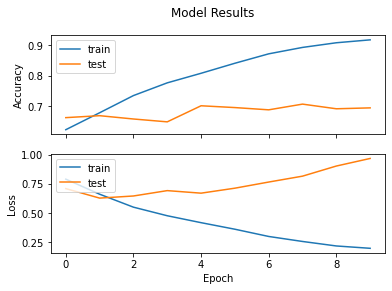

In [219]:
visualize_training_results(history)

# Nueral Network with Regularization

In [234]:
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=True))
model.add(layers.Flatten()) # flattening these layers down before connecting to dense layer
model.add(Dropout(0.5))
model.add(layers.Dense(250, activation='sigmoid',
                       kernel_regularizer=regularizers.l2(l2=1e-3),
                       bias_regularizer=regularizers.l2(1e-3),
                      activity_regularizer=regularizers.l2(1e-3)))
model.add(Dropout(0.5))
model.add(layers.Dense(250, activation='sigmoid',
                       kernel_regularizer=regularizers.l2(l2=1e-3),
                       bias_regularizer=regularizers.l2(1e-3),
                      activity_regularizer=regularizers.l2(1e-3)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 19, 50)            356850    
_________________________________________________________________
flatten_7 (Flatten)          (None, 950)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 950)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 250)               237750    
_________________________________________________________________
dropout_9 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 250)               62750     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                

In [235]:
history = model.fit(X_train_processed, y_train, 
                    batch_size=50, 
                    epochs=10, 
                    validation_data=(X_val_processed, y_val))

Epoch 1/10
123/123 [==============================] - 3s 21ms/step - loss: 1.0629 - accuracy: 0.6669 - val_loss: 0.8843 - val_accuracy: 0.6619
Epoch 2/10
123/123 [==============================] - 2s 17ms/step - loss: 0.8150 - accuracy: 0.6800 - val_loss: 0.7747 - val_accuracy: 0.6629
Epoch 3/10
123/123 [==============================] - 2s 17ms/step - loss: 0.7407 - accuracy: 0.6860 - val_loss: 0.7201 - val_accuracy: 0.6830
Epoch 4/10
123/123 [==============================] - 2s 18ms/step - loss: 0.7041 - accuracy: 0.7048 - val_loss: 0.6947 - val_accuracy: 0.7001
Epoch 5/10
123/123 [==============================] - 2s 17ms/step - loss: 0.6808 - accuracy: 0.7177 - val_loss: 0.6976 - val_accuracy: 0.7036
Epoch 6/10
123/123 [==============================] - 2s 16ms/step - loss: 0.6536 - accuracy: 0.7247 - val_loss: 0.6707 - val_accuracy: 0.7065
Epoch 7/10
123/123 [==============================] - 2s 17ms/step - loss: 0.6320 - accuracy: 0.7497 - val_loss: 0.6681 - val_accuracy: 0.7153

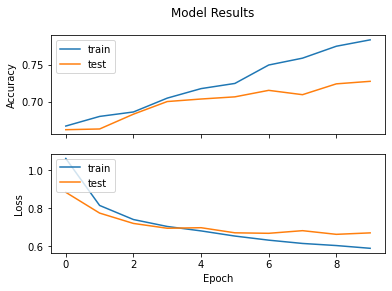

In [236]:
visualize_training_results(history)